In [3]:
from notebook_utils import resolve_paths_from_parent_directory
resolve_paths_from_parent_directory()
# auto reload notebook deps
%reload_ext autoreload
%autoreload 2

In [4]:
import pandas as pd

df_celeb_raw = pd.read_csv("../data/celebrity/Top-1000-Celebrity-Twitter-Accounts.csv")

In [5]:
df_celeb_raw

,twitter,domain,name,type
0,katyperry,katyperry.com,KATY PERRY,celebrity
1,justinbieber,smarturl.it,Justin Bieber,celebrity
2,taylorswift13,grmypro.co,Taylor Swift,celebrity
3,rihanna,rihannanow.com,Rihanna,celebrity
4,ladygaga,NaN,The Countess,celebrity
...,...,...,...,...
991,Zedd,smarturl.it,Zedd,celebrity
992,SleepintheGardn,katuriankaturiankaturian.tumblr.com,Troian,celebrity
993,therealjuicyj,thejuicyj.com,juicy j,celebrity
994,manugavassi,manugavassi.com.br,Manu Gavassi,celebrity


In [6]:
from api.twitter import fetch_users
import numpy as np
import math

user_data = []
errors = []
for handle_chunk in np.array_split(
    df_celeb_raw.twitter, 
    math.ceil(df_celeb_raw.shape[0] / 100)
):
    resp = fetch_users(handle_chunk)
    user_data += resp["data"]
    errors += resp["errors"]

Successfully loaded Twitter API keys


2021-10-20 15:17:43.632 INFO    root: GET request to https://api.twitter.com/2/users/by, response 200
2021-10-20 15:17:43.970 INFO    root: GET request to https://api.twitter.com/2/users/by, response 200
2021-10-20 15:17:44.439 INFO    root: GET request to https://api.twitter.com/2/users/by, response 200
2021-10-20 15:17:44.782 INFO    root: GET request to https://api.twitter.com/2/users/by, response 200
2021-10-20 15:17:45.140 INFO    root: GET request to https://api.twitter.com/2/users/by, response 200
2021-10-20 15:17:45.488 INFO    root: GET request to https://api.twitter.com/2/users/by, response 200
2021-10-20 15:17:45.849 INFO    root: GET request to https://api.twitter.com/2/users/by, response 200
2021-10-20 15:17:46.172 INFO    root: GET request to https://api.twitter.com/2/users/by, response 200
2021-10-20 15:17:46.853 INFO    root: GET request to https://api.twitter.com/2/users/by, response 200
2021-10-20 15:17:47.172 INFO    root: GET request to https://api.twitter.com/2/use

In [7]:
df_celeb = df_celeb_raw.rename(
    columns={"twitter": "twitter_username"}
)
user_data_by_username = {user["username"]: user for user in user_data}

# remove rows that are missing data
df_celeb = df_celeb[df_celeb.twitter_username.apply(lambda u: u in user_data_by_username)]

len(df_celeb)

939

In [8]:
user_data[0]

{'description': 'Love. Light.',
 'public_metrics': {'followers_count': 108789024,
  'following_count': 236,
  'tweet_count': 11460,
  'listed_count': 128752},
 'name': 'KATY PERRY',
 'verified': True,
 'id': '21447363',
 'created_at': '2009-02-20T23:45:56.000Z',
 'username': 'katyperry'}

In [9]:
df_celeb["followers_count"] = df_celeb.twitter_username.apply(
    lambda u: user_data_by_username[u]["public_metrics"]["followers_count"]
)
df_celeb["tweet_count"]  = df_celeb.twitter_username.apply(
    lambda u: user_data_by_username[u]["public_metrics"]["tweet_count"]
)
df_celeb["name"]  = df_celeb.twitter_username.apply(
    lambda u: user_data_by_username[u]["name"]
)
df_celeb["created_at"]  = df_celeb.twitter_username.apply(
    lambda u: user_data_by_username[u]["created_at"]
)
df_celeb["id"]  = df_celeb.twitter_username.apply(
    lambda u: user_data_by_username[u]["id"]
)
df_celeb.head()

,twitter_username,domain,name,type,followers_count,tweet_count,created_at,id
0,katyperry,katyperry.com,KATY PERRY,celebrity,108789024,11460,2009-02-20T23:45:56.000Z,21447363
1,justinbieber,smarturl.it,Justin Bieber,celebrity,114060688,31380,2009-03-28T16:41:22.000Z,27260086
2,taylorswift13,grmypro.co,Taylor Swift,celebrity,88903543,691,2008-12-06T10:10:54.000Z,17919972
3,rihanna,rihannanow.com,Rihanna,celebrity,103256018,10587,2009-10-02T21:37:33.000Z,79293791
4,ladygaga,NaN,Lady Gaga,celebrity,83801008,9645,2008-03-26T22:37:48.000Z,14230524


<AxesSubplot:ylabel='Frequency'>

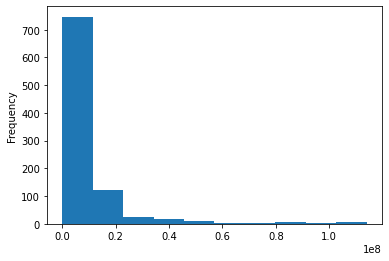

In [10]:
df_celeb.followers_count.plot.hist()

## Enhance with Tweet Counts API results

In [11]:
from datetime import datetime, timezone
from dateutil.relativedelta import relativedelta
from api.twitter import fetch_historical_counts

def get_query_for_username(username):
    return f"@{username} OR from:{username} OR to:{username}"

def get_tweet_counts_by_username(username):
    start_time = datetime.strptime(
        "2021-01-01", 
        '%Y-%m-%d'
    )
    end_time = start_time + relativedelta(months=3)

    granularity = "day" # hour

    return fetch_historical_counts({
        "query": get_query_for_username(username),
        "start_time": datetime.combine(
            start_time,
            datetime.min.time()
        ).replace(tzinfo=timezone.utc).isoformat(),
        "end_time": datetime.combine(
            end_time,
            datetime.min.time()
        ).replace(tzinfo=timezone.utc).isoformat(),
        "granularity": granularity
    })

In [12]:
tweet_count_data_by_user = {}

In [34]:
import time

i = 0
for user in df_celeb_raw.twitter.sort_values():
    if (i < 300):
        try:
            if user not in tweet_count_data_by_user:
                i += 1
                tweet_count_data_by_user[user] = get_tweet_counts_by_username(user)
        except:
            print(f"Rate limited for {user}, waiting 15 sec..")
            time.sleep(15)

In [35]:
len(tweet_count_data_by_user)

986

In [36]:
import pickle

# Safety for not overriding the cache with an empty dict...
if (len(tweet_count_data_by_user) >= 986):
    with open("../data/celebrity/tweet_count_data_by_user", "wb") as f:
        pickle.dump(tweet_count_data_by_user, f)

In [37]:
import pickle
with open("../data/celebrity/tweet_count_data_by_user", "rb") as f:
    cached_tweet_count_data_by_user = pickle.load(f)
len(cached_tweet_count_data_by_user)

986

In [31]:
df_celeb.drop(["domain", "type"], axis=1).to_csv("../data/celebrity/enhanced_1k_celebrities.csv")

In [ ]:
## TODO, convert tweet_count_data_by_user to timeseries, sum counts and detect spikes